# Procedure for quantum state preparation (QSP) experiment.

QSP is presented clearly in [this publication](https://arxiv.org/abs/2306.17422). The basic idea is that we have two unitary $U(\theta)$ and $V^{\dagger}$, we optimize the parameter $\theta$ until $\theta^{*}$ such that $U(\theta^{*})V^{\dagger}=I$.

So we will do experiments with various $U$, $V^{\dagger}$ and optimize strategy. 

Some notation for hyperparameter:

(important)
- Ansatz: $U$ (defined in `qtm.ansatz`)
- Optimize circuit: $u$ (ansatz when repeat $L$ times)
- State: $V^{\dagger}$ (defined in `qtm.state`)
- Number of qubit: $n$ (`num_qubits`)
- Number of layer (for ansatz): $L$ (`num_layers`)
- $\theta$: theta (if $\theta$ is scalar), thetas (if $\theta$ is 1-d numpy array) and thetass (if $\theta$ is 2-d numpy array).

(not important)
- Number of iteration: $n_{iter}$ (`num_iter / iter`)
- Optimizer: `sgd`, `adam` or `qng` family, the best optimizer is `adam`.

Here is your task, run the below codes with:

- $U$ is `qtm.ansatz.g2`, `qtm.ansatz.g2gn` or `qtm.ansatz.g2gnw`.
- $V^{\dagger}$ is `qtm.state.create_GHZ_state(num_qubits).inverse()`, `qtm.state.create_W_state(num_qubits).inverse()`, `qtm.state.create_AME_state(num_qubits).inverse()` or `qtm.state.create_haar_state_inverse(num_qubits)`
- $n$ from 3 - 10 (3 - 5 for AME state).
- $L$ from 1 - 10 (Note: if we run L = 3 and achieve fidelity ~ 0, then no need to run with larger $L$).
- $n_{iter}$: default is 100, if loss value is not ~ 0, you can plot loss_values curve by compiler.plot() method, if it can decrease in the next iteration, then increasing $n_{iter}$ upto 300.

The detailed guideline is below. If you can use the server A6000, let's view `multi_process_script.py`.

In [1]:
import sys
sys.path.insert(0, '..')
import qtm.qcompilation
import matplotlib.pyplot as plt
import qiskit
import qtm.qsp
import qtm.ansatz, qtm.state
%load_ext autoreload
%autoreload 2

### Quantum State Preparation (QSP) problem

First, using Quantum Compilation (QC) to find optimized $\theta$

In [9]:
num_qubits = 3
num_layers = 1
optimizer = 'adam'
compiler = qtm.qcompilation.QuantumCompilation(
    u = qtm.ansatz.g2gn(num_qubits, num_layers),
    vdagger = qtm.state.create_w_state(num_qubits).inverse(),
    optimizer = optimizer,
    loss_func = 'loss_fubini_study'
)
compiler.fit(num_steps = 10, verbose = 1)

Step: 100%|██████████| 10/10 [00:02<00:00,  4.39it/s]


In [6]:
compiler.save(qtm.ansatz.g2gn, 'haar', './')

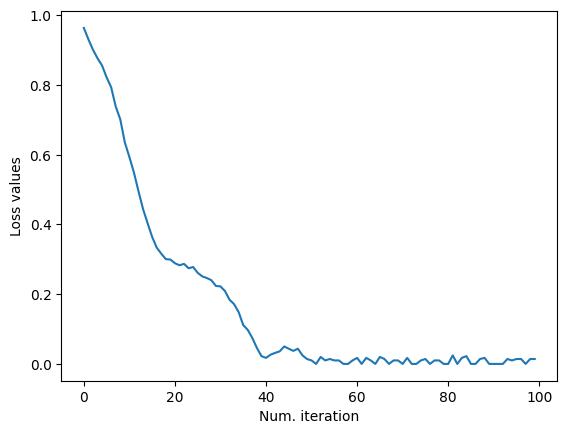

In [8]:
compiler.plot()

Then, create QSP object from compiler, note that Quantum Compilation (QC) is the superset of QSP. There are multiple way to initialize a QSP object: from compiler, from file or using constructor.

In [4]:
qspobj = qtm.qsp.QuantumStatePreparation.load_from_compiler(
    compiler = compiler, ansatz = qtm.ansatz.g2gn)

**Important**, you must save the result in the folder experiments/qsp/, where the 'state' argument is the name of state which is need to prepare. The name of file will be automatically create followed this format:

```
[state]_[ansatz]_[num_qubits]_[num_layers].qspobj
```

In [6]:
qspobj.save(state = 'ame', file_name='../experiments/qsp/')

Last step, load QSP from saved file and check its properties.

In [14]:
qspobj2 = qtm.qsp.QuantumStatePreparation.load_from_file('../experiments/qsp/ghz_g2_3_1.qspobj')

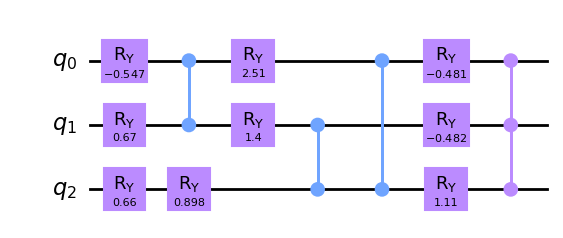

In [17]:
qspobj2.qc.draw('mpl')